*Andrew Calderwood*

In [1]:
import os
from os.path import basename, dirname, join, exists
import sys

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

from scipy.optimize import minimize

from datetime import datetime
from datetime import timedelta
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# from pandas.tseries import converter

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')

flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
import flopy 
import flopy.utils.binaryfile as bf


In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning'
tprogs_id = '_no_cond_c3d'


data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [4]:
git_dir = join(doc_dir, 'GitHub','CosumnesRiverRecharge')
fxn_dir = git_dir+'/python_utilities'
if fxn_dir not in sys.path:
    sys.path.append(fxn_dir)
# sys.path
# import muskingum_recharge as mr

from importlib import reload
# reload(mr)

In [5]:
nrow = 100
ncol = 230
rows = np.repeat(np.arange(0,nrow),ncol)
cols = np.tile(np.arange(0,ncol),nrow)

# dem data for cropping above land surface
# dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_linear.tsv')
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')

zs = gpd.read_file(gwfm_dir+'/DIS_data/grid_elevation_m_statistics.shp')
# columns with different quantiles 0 to 100% of elevation
q_cols = zs.columns[zs.columns.str.contains('perc')]
df_elevs = zs[q_cols]

# convert quantile dataframe to a 3D array
arr_elev = np.zeros((df_elevs.shape[1], zs.row.max(),zs.column.max()))
for n in np.arange(0,df_elevs.shape[1]):
    arr_elev[n, zs.row-1, zs.column-1] = df_elevs.iloc[:,n]

0.47565406981303726

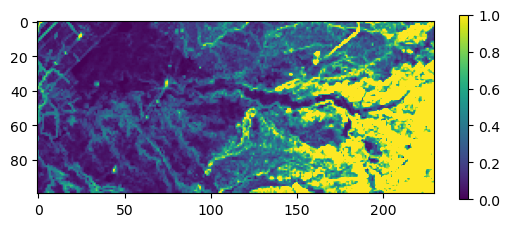

In [6]:
plt.imshow(np.mean(np.diff(arr_elev, axis=0), axis=0), vmax=1)
plt.colorbar(shrink=0.5)
np.mean(np.diff(arr_elev, axis=0))

# No flow routing, recharge loss only

In [8]:
# Q_cfs = 22500 # 5 year
# # Q_cfs = 2000 # 1ish year

# Q_cms = Q_cfs*(0.3048**3) # convert to cubic meters per second


In [9]:
import muskingum_recharge
reload(muskingum_recharge)

from muskingum_recharge import min_Q, mannings, calc_depth_arr, xs_setback, gridded_interpolation


In [10]:
import h5py
f = h5py.File(join(chan_dir, 'setback_locs.hdf5'), "r")
local_str_setbacks = f['setbacks']['local'][:]
str_setbacks = f['setbacks']['regional'][:]

f.close()

In [11]:
setbacks = np.arange(0, 3400,200)
# smoothed XS data used for setback analysis
xs_levee_smooth = pd.read_csv(chan_dir+'xs_levee_smooth.csv', index_col='dist_from_right_m')
num_segs = xs_levee_smooth.shape[1]

# load array identifying row,col to XS id (1,28)
xs_arr = np.loadtxt(chan_dir+'XS_num_grid_reference.tsv')

# load flood typology characteristics (based on daily data 1908 - 2014) - median values 
#"cms_pk" for peak discharge, "pk_loc" for time to peak, and "log_no_d" for duration
flood_type = pd.read_csv(join(box_dir, 'whipple_grp6_w97ftmedians.csv'),index_col='Group.1')


In [12]:
Q_cms = flood_type.loc[1,'cms_pk']

In [31]:
soil_thick=2
# fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth.tsv' # from linear dem but also seems off
fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth_dem_mean.tsv' # mean dem with newest cleaning function

# units of m/day
soil_K_out = np.loadtxt(fn, delimiter='\t')
soil_K = np.reshape(soil_K_out, (100, nrow, ncol))
# convert soil conductivity from m/d to m/s and apply vertical anisotropy factor
vani = 100
soil_K = (soil_K/vani)/86400

In [29]:
# flow_percentile=87 # for permeameter (flow threshold)
flow_percentile=6 # for connec3d (points of connectivity)

hf_tot_in =  np.loadtxt(data_dir+'surface_highflow_by_realization_'+str(flow_percentile)+'.tsv',delimiter = '\t')
hf_tot = np.reshape(hf_tot_in, (100, nrow, ncol))


In [75]:

# check that soil map aligns with locations of connected paths
# fig,ax = plt.subplots(dpi=600)
# temp = np.copy(soil_K[t])
# temp[~hf_tot[t].astype(bool)] = np.nan
# ax.imshow(temp)

# the maps align and show that only along the edges do we see the lower K values do too mixing with silt/mud

In [36]:
# I checked the new soil maps against the HCP maps and they align now.
# plt.imshow(soil_K[0])
# plt.show()
# plt.imshow(hf_tot[0])

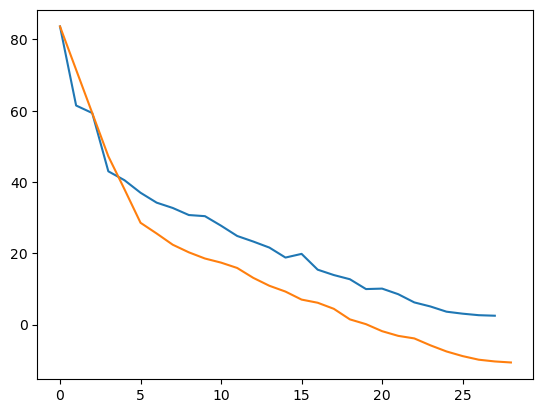

In [37]:
# find minimum from channel center
xs_mins = xs_levee_smooth.loc[3100:3300].min(axis=0)
xs_mins.index = xs_mins.index.astype(int)
# xs_mins.interpolate(method='linear').plot()
slope = xs_mins.diff().rolling(2, center=True, closed='right').mean().bfill()/2000*-1
adj_xs_mins = np.append(xs_mins[0], (xs_mins[0]-slope.cumsum()*2000))

# (xs_mins.diff()/-2000).plot()
# slope.plot()
# plt.show()
xs_mins.plot()
plt.plot(adj_xs_mins)

In [38]:
# the minimum elevation for each subsegment applied outward across the transects
xs_mins_arr = np.loadtxt(chan_dir+'subsegments_xs_mins.tsv', delimiter='\t')
# need to correct segment definition to where the xs_mins subsegment data is
xs_arr[np.isnan(xs_mins_arr)] = np.nan

In [39]:
# rating curves for each segment and setback
xs_flow_all = pd.read_csv(join(chan_dir,'all_xs_50pt_rating_curves.csv'))

def depth_match(seg_flow, flow):
    """ Given a XS (nseg, setback) return the expected depth (m) given a flow (cms)"""
    # find flows above and below the input flow
    flow_diff = (seg_flow.flow_cms-flow)
    f_high = flow_diff[flow_diff>0].argsort().index[0]
    f_low = flow_diff[flow_diff<0].argsort().index[-1]
    match_d = seg_flow.loc[[f_low, f_high]].sort_values('flow_cms')
    # linearly interpolate to calculate exact depth
    flow_slope = (match_d.iloc[1].flow_cms-match_d.iloc[0].flow_cms)/(match_d.iloc[1].depth_m-match_d.iloc[0].depth_m)
    out_depth = match_d.iloc[0].depth_m + (flow-match_d.iloc[0].flow_cms)/flow_slope
    return(out_depth)

In [40]:
nseg = 10
setback=3200
seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
# seg_flow
depth_match(seg_flow, flow=500)

1.814347802070308

Text(0, 0.5, 'Flow ($m^3/s$)')

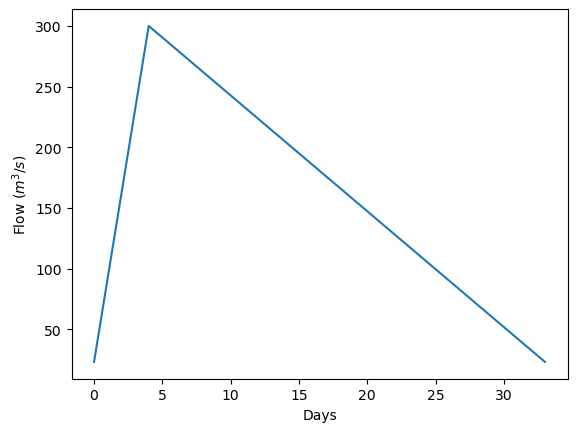

In [41]:
# for n in flood_type.index:
# 1, 2, 3 are floods long enough to apply to analysis
ft=2
# typical winter baseflow, peak flow, peak location, total time (days)
# flow of 23 m3/s listed by Whipple as floodplain cutoff
q_base = 23 # 200*(0.3048**3)
q_peak = flood_type.loc[ft,'cms_pk']
# total duration in days 
T = int(10**flood_type.loc[ft,'log_no_d'])
p_l = flood_type.loc[ft,'pk_loc']
tp = int(p_l*T)

q_rise = np.linspace(q_base, q_peak, tp)
q_fall = np.linspace(q_peak, q_base, (T-tp+1))
q_in = np.append(q_rise, q_fall[1:])
plt.plot(q_in)
plt.xlabel('Days')
plt.ylabel('Flow ($m^3/s$)')

# Flow loss procedure
1. Allocate arrays for:  
    1. flow (n realizations, n setbacks, n segments +1)  
    2. depth (n setbacks, nrow, ncol)  
    3. water surface elevation (n setbacks, nrow, ncol)  
    4. recharge (n realizations, n setbacks, nrow, ncol)  
2. Primary iteration:  
    1. Given a cross-section with a specified width for a given setback  
    2. Calculate the depth in the channel from the flow with Manning Equation  
    3. Add depth to cross-section minimum elevation to calculate water surface elevation for the given setback and segment  
3. Secondary Iteration:  
    1. Given a segment identify which cells have a water surface elevation above ground surface (i.e., inundated)  
    2. Calculate recharge based on inundated area, hydraulic gradient due to flood depth and vertical conductivity  
    3. Sum of recharge by segment  
    4. Calculate flow leaving the segment by subtracting recharge from flow entering the segment  
4. Optional Iteration:
    1. Apply a sequence of flows that include the rising limb and falling limb in addition to the peak flow
    2. Calculate total recharge from this continuous event
5. Outermost Iteration:  
    Complete these depth, recharge, flow calculations for each subsurface realization  
    

In [42]:
from scipy.optimize import minimize_scalar

# depths = np.zeros((len(setbacks), xs_levee_smooth.shape[1]))
Q = np.zeros((100, len(setbacks), xs_levee_smooth.shape[1]+1))
Q[:,:,0] = Q_cms
# save depth arrays for each setbacks
d_arr = np.zeros((len(setbacks), nrow, ncol))
wse_arr = np.zeros((len(setbacks), nrow, ncol))
# save high recharge flows
rch_hf_arr = np.zeros((100, len(setbacks), nrow, ncol))




Rather than focusing on improving the solver iteration which isn't that bad (21 iterations isn't great but it could be worse), I should work on solution: updating roughness based on cross-section width, include levee wall roughness in wetted perimeter. Look at sensitivity of vertical conductivity. Summarize recharge by time period of flood (travel time is 13.2 hours/45 km per Whipple, about 0.3 hrs per 1 km) which is about 0.6 hrs per 2km to multiply by the recharge rate.   
The current set up with a flow minus recharge makes sense if we assume a temporary steady state is reached (true for sub half hour), but if I want to start calculating volumes for transient events then I need to account for the duration.

Whipple notes a floodplain inundation threshold of 23 m3/s at MHB where the lowest lying floodplain areas connect.

In [ ]:
# using rating curve method with linear interpolation is 15x faster than minimize scalar

In [50]:
# runs a singular flow value
from time import time
# takes ~45 minutes
t=0
tic = time()
n = 0.048 # assume constant roughness for now

for t in np.arange(0,1):
    # iterate across all cross-sections
    for nseg in np.arange(0,xs_levee_smooth.shape[1]):
        # iterate across all setbacks
        for s,setback in enumerate(setbacks):
            # for a given setback imagine there is an impenetrable levee blocking overbank flow
#             xs_elevs = xs_levee_smooth.iloc[:,nseg][3100-setback:3300+setback]
            xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg], setback)
            # solve for depth that matches given flow
            if Q[t, s,nseg] >0:
                res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q[t, s,nseg]), bounds=(0,10), method='bounded')
                depth = res.x
#                 seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
#                 depth = depth_match(seg_flow, flow=Q[t, s,nseg])
            else:
                depth = 0
            # join depth calculated at cross-section to corresponding model cells and corresponding setback
#             wse_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth + xs_elevs.min()
#             d_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth
            wse_arr[s,(xs_arr==nseg)&(str_setbacks[s]==1)] = depth + xs_elevs.min()
            d_arr[s,(xs_arr==nseg)&(str_setbacks[s]==1)] = depth 
        # identify wse above surface elevation 
        d_arr = d_arr* (wse_arr > dem_data)
        # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
        # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
        rch_hf_arr[t,:,:,:] += (xs_arr==nseg)*(soil_K[t,:,:])*hf_tot[t,:,:] *(200*200)*((d_arr* + soil_thick)/soil_thick)
        Q[t, :, nseg+1] = Q[t, :, nseg] - np.nansum(rch_hf_arr[t,:, xs_arr==nseg], axis=(0))
        
toc = time()
print((toc-tic)/3600)

0.003779599799050225


In [28]:
from time import time
from scipy.optimize import minimize_scalar



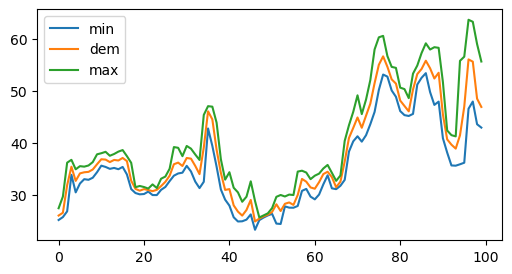

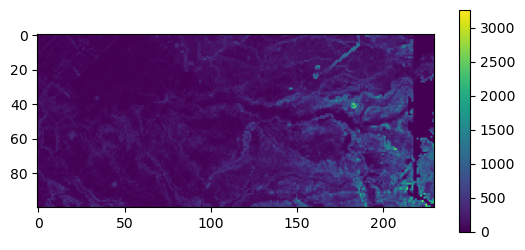

In [29]:
# find difference between water surface and cell elevations
diff = wse_arr[tp-1,-1,:] - arr_elev
diff[diff<0] = np.nan
# find the highest elevation above which there is water
bot_q = np.argmin(diff, axis=0)[rows,cols] - 1
bot_q[bot_q<0] = 0
top_q = np.argmin(diff, axis=0)[rows,cols] 
# find percentage of interim quantile
perc_q = (dem_data[rows,cols] - arr_elev[bot_q, rows,cols])/(arr_elev[top_q, rows,cols] +1E-3 - arr_elev[bot_q, rows,cols])
# percent of cell area covered by flood
perc_A = np.reshape(bot_q + perc_q, (nrow,ncol))/10

fig,ax = plt.subplots(figsize=(6,3))
n = 150
ax.plot(arr_elev[0][:,n], label='min')
ax.plot(dem_data[:,n], label='dem')
ax.plot(arr_elev[10][:,n], label='max')
ax.legend()
fig,ax=plt.subplots()
ax.imshow(perc_A)
plt.colorbar(ax.images[0], shrink=0.6)


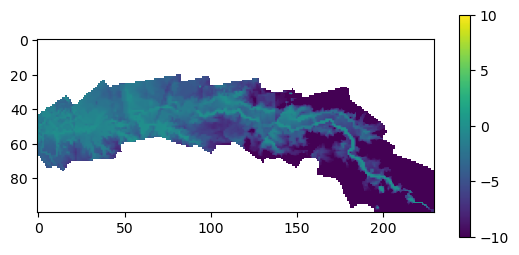

In [31]:
plt.imshow(xs_mins_arr - arr_elev[0],vmin=-10, vmax=10)
plt.colorbar(shrink=0.6)

In [ ]:
# wse_temp = np.zeros((nrow,ncol))
# nseg = 27
# s=0
# depth = 1
# for s in np.arange(0,17):
#     for nseg in [27]:#np.arange(0,27):
#         fp_zon = (xs_arr==nseg)&(str_setbacks[s]==1)
# #         wse_temp[fp_zon] = depth + xs_mins_arr[fp_zon]
# #         if any(np.isnan(xs_mins_arr[fp_zon])):
# #             print('Seg',str(nseg),'Setback',str(s), xs_mins_arr[fp_zon])
# #         # calculate depth of water at different elevation percentiles for segment and setback
# #         diff = wse_temp*fp_zon - arr_elev
# #         # when depth is negative remove
# #         diff[diff<0] = 0 #np.NaN
# #         # only keep cells where water level is above lowest elevation
# #         diffmax = np.nanmax(diff, axis=0)
#         print(np.nanmax(xs_mins_arr[fp_zon]))

In [43]:
def arr_to_h5(Q, rch_hf_arr, d_arr, h5_fn):
    # convert arrays of annual rates to hdf5 files individually
    f = h5py.File(h5_fn, "w")
    grp = f.require_group('array') # makes sure group exists
    grp.attrs['units'] = 'cubic meters/second'
    grp.attrs['description'] = 'Each layer of the array is a day in the event'
    dset = grp.require_dataset('flow', Q.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = Q
    dset = grp.require_dataset('rch_hf', rch_hf_arr.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = rch_hf_arr
    dset = grp.require_dataset('depth', d_arr.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = d_arr
    f.close()
    


In [121]:

def realization_recharge(t, str_setbacks, region, save=True):
    # allocate arrays - num flow steps, num setbacks, num segments
    Q = np.zeros((q_in.shape[0], len(setbacks), xs_levee_smooth.shape[1]+1))
    # set inflow for segment 1 across all setbacks and for all times
    # rate of cubic meters per second
    Q[:,:,0] = np.repeat(q_in.reshape(-1,1), len(setbacks), axis=1)
    # save depth arrays for each setbacks
    d_arr = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))
    wse_arr = np.zeros((len(setbacks), nrow, ncol))
    cell_frac = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))
    # save high recharge flows
    rch_hf_arr = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))

    tic = time()
    n = 0.048 # assume constant roughness for now

    # iterate across streamflows
    for qn in np.arange(0, q_in.shape[0]):
        # iterate across all cross-sections
        for nseg in np.arange(0,xs_levee_smooth.shape[1]):
            # iterate across all setbacks
            for s,setback in enumerate(setbacks):
                # for a given setback imagine there is an impenetrable levee blocking overbank flow
                xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg], setback)
                # boolean of row,col cells that fall within the segment and setback
                fp_zon = (xs_arr==nseg)&(str_setbacks[s]==1)
                # solve for depth that matches given flow, assume less than 1 cms is too small to calculate
                if Q[qn, s,nseg] >1:
                    seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
                    depth = depth_match(seg_flow, flow=Q[qn, s, nseg])
                else:
                    depth = 0
                # join depth calculated at cross-section to corresponding model cells and corresponding setback
                # add elevation to minimum to apply segment midpoint as elevation rather than lowest point
#                 wse_arr[s, fp_zon] = depth + xs_elevs.min() + slope.iloc[nseg]*1000
                wse_arr[s, fp_zon] = depth + xs_mins_arr[fp_zon]
#                 if any(np.isnan(xs_mins_arr[fp_zon])):
#                     print('Seg',str(nseg),'Setback',str(s), xs_mins_arr[fp_zon])
                # calculate depth of water at different elevation percentiles for segment and setback
                # to account for flood connectivity and avoid negligible, require a minimum of 0.1 m 
                diff = wse_arr[s,:]*fp_zon - 0.1 - arr_elev
                # when depth is negative remove
                diff[diff<0] = 0 #np.NaN
                # only keep cells where water level is above lowest elevation
                diffmax = np.nanmax(diff, axis=0)
                # keep cells where diffmax >0 
                x,y = np.where(diffmax>0)
                # find the highest elevation above which there is water, subtract 1 uses lower percentile
                # where the wse was below the minimum ignore
                bot_q = np.argmin(diff, axis=0)[x,y] - 1
                bot_q[bot_q<0] = 0
                top_q = np.argmin(diff, axis=0)[x,y]
                # find percentage of interim quantile
                perc_q = (wse_arr[s, x,y] - arr_elev[bot_q, x,y])/(arr_elev[top_q, x,y] +1E-3 - arr_elev[bot_q, x,y])
                # percent of cell area covered by flood
                cell_frac[qn, s,x,y] = (bot_q + perc_q)/10
                # depth for each cell is difference between water surface and average flooded ground elevation
                d_arr[qn, s,fp_zon] = np.nanmean(diff, axis=0)[fp_zon] #depth 
                # identify wse above surface elevation 
#                 d_arr[qn,:] = d_arr[qn,:] * cell_frac[qn] # caused overflow error
            # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
            # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
            q_seep = (soil_K[t,:,:])*hf_tot[t,:,:]*(200*200)*((d_arr[qn,:] + soil_thick)/soil_thick)
            rch_hf_arr[qn,:,:,:] += (xs_arr==nseg) * q_seep * cell_frac[qn]
            # identify when the flow is less than the recharge predicted and recharge > 0 
            dry = (Q[qn, :, nseg] < np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0)) & (np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0)>0)
            if any(dry):
                # where the cells will end dry, reduce recharge so it sums to the flow into segment
    #             scale = (Q[qn, :, nseg][dry]/np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0))[dry])
                scale = (Q[qn, :, nseg]/(np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0)))) 
                scale = np.where(scale > 1, 1,scale) # only scale when flow is less than recharge
#             if any(scale<1):
#                 rch_hf_arr[qn, :,xs_arr==nseg][:,dry] *= scale
                rch_hf_arr[qn, :,xs_arr==nseg] *= scale
                print('scale', np.round(np.median(scale),2))
            Q[qn, :, nseg+1] = Q[qn, :, nseg] - np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0))
            if any(Q[qn,:,nseg+1]<0):
                print(qn, nseg+1)
                
    # saving all of the flow at all steps, setbacks is needed to post-process
    if save:
        base_fn = join(data_dir, region, 'type'+str(ft), 'r'+str(t).zfill(3)+'_')
        arr_to_h5(Q, rch_hf_arr, d_arr, base_fn+'output.hdf5')
    toc = time()
    print('Ran in %.2f' %((toc-tic)/3600), 'hours')
    return(Q, rch_hf_arr, d_arr, cell_frac)


In [129]:
# n = 0.048
# nseg=13
# s=7
# setback = setbacks[s]

# xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg].copy(), setback)
# Q_chk = mannings(3.03, xs_elevs, n, slope.iloc[nseg])
# print('Q calc %.2f' %Q_chk, 'Q in %.2f' %Q[qn,s,nseg])


Q calc 126.94 Q in 114.05


In [378]:

# check why the addition of dry segment check didn't fix negative flows
qn = 0
nseg = 24

# identify when the flow is less than the recharge predicted and recharge > 0
dry = (Q[qn, :, nseg] < np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0)) & (np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0)>0)
# where the cells will end dry, reduce recharge so it sums to the flow into segment
# scale = (Q[qn, :, nseg][dry]/np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0))[dry])
if any(dry):
    print('Recharge exceeds flow')
print('Flow nseg -1   ',np.round(Q[qn, :, nseg-1],2))
print('Recharge nseg-1',np.round(np.nansum(rch_hf_arr[qn,:, xs_arr==nseg-1], axis=0),2))
# the flow into the next segment isn't equally the flow in the previous minus recharge with the dry adjustment
print('Flow nseg     ',np.round(Q[qn, :, nseg],2))
print('Recharge nseg  ',np.round(np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0),2))

# even though flow is negative there is somehow depth at these locations
print('Depth nseg    ',np.round(np.nanmax(d_arr[qn,:,xs_arr==nseg], axis=0),2))
# this may be an issue with how the minimum XS elevation is defined, bascially the min XS value should be consistent
print('Flow nseg +1  ', np.round(Q[qn, :, nseg+1],2))
# once flow hits negative then there is no longer depth so no more recharge at least
# when flow is less than recharge and greater than 0 then scaling is appropriate
# I'm get at least a couple of NAs in the scaling which will cause issues

# if flow is already negative then this scaling function does not help, it would be adding flow from recharge which is wrong
# scale = (Q[qn, :, nseg][dry]/np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0))[dry])
scale = (Q[qn, :, nseg]/np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0)))
scale = np.where(scale > 1, 1,scale)
print('Scale nseg     ', scale)

Recharge exceeds flow
Flow nseg -1    [22.19 22.26 22.08 21.96 21.81 21.68 20.5  20.27 20.2  20.21 20.07 20.06
 20.08 20.08 20.08 19.32 19.15]
Recharge nseg-1 [0.   0.96 1.17 2.54 2.53 2.78 1.65 1.47 1.59 1.59 0.99 0.99 0.99 0.99
 0.94 0.93 0.93]
Flow nseg      [22.19 21.3  20.91 19.43 19.28 18.89 18.84 18.79 18.61 18.63 19.08 19.07
 19.1  19.1  19.14 18.39 18.22]
Recharge nseg   [ 0.25  0.21 24.4  48.95 43.37 43.12 49.   49.45 49.16 49.21 48.67 41.25
 41.8  42.28 42.43 42.05 41.94]
Depth nseg     [0.31 0.25 1.84 1.8  1.54 1.53 1.64 1.66 1.65 1.65 1.63 1.44 1.44 1.44
 1.44 1.43 1.42]
Flow nseg +1   [ 21.94  21.1   -3.5  -29.52 -24.1  -24.23 -30.15 -30.66 -30.55 -30.59
 -29.59 -22.17 -22.71 -23.18 -23.29 -23.67 -23.72]
Scale nseg      [1.         1.         0.8567445  0.39689055 0.444413   0.43807569
 0.38459889 0.38005658 0.37850387 0.37844615 0.39207704 0.46241291
 0.45680006 0.4516957  0.45107897 0.43726007 0.43442337]


# Run code

In [122]:
# a couple realizations failed to write output including 48
t=5
Q, rch_hf_arr, d_arr, cell_frac = realization_recharge(t, str_setbacks, 'regional', save=False)



scale 1.0
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
scale 1.0
33 20
33 21
33 22
33 23
33 24
33 25
33 26
33 27
33 28
Ran in 0.10 hours


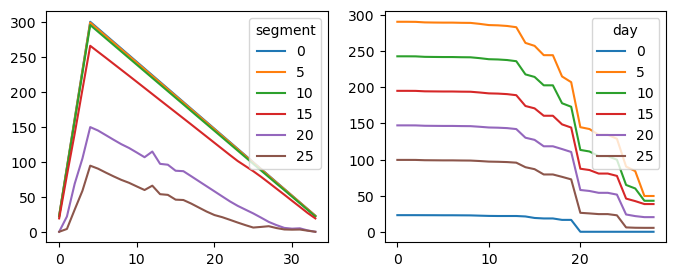

In [47]:
fig,ax = plt.subplots(1,2, figsize=(8,3))# time series
# select segments all times
for n in [0,5, 10,15,20,25]:
    ax[0].plot(Q[:,-1,n], label=n)
ax[0].legend(title='segment')
# plt.show()
# first time all segs
# longitudinal losses
for n in [0,5, 10,15,20,25]:
    ax[1].plot(Q[n,-1, :],label=n)
ax[1].legend(title='day')
# rch_hf_arr.sum(axis=(2,3))[:,-1]

In [48]:
# calculate recharge for each flow and setback, daily average in m3/s
rch_q_sum = pd.DataFrame(np.sum(rch_hf_arr, axis=(2,3)), columns= setbacks).transpose()
# calculate sum for all flows (daily average)
rch_sum = rch_q_sum.sum(axis=1)
# convert to AF/day and will have the total AF recharged because already summed by day
rch_sum_AF = rch_sum*86400/((0.3048**3)*43560)

# if we divide by the setback area we will get the depth of recharge per setback area
setback_area = [np.sum(str_setbacks[s]== s)*200*200 for s in np.arange(0,len(setbacks)) ]

# (rch_sum_AF/setback_area).plot()

In [73]:
# tp = 5
# s = 5
# fig,ax=plt.subplots(1,2,figsize=(8,4))
# for s in [0,5,10,15]:
#     temp = np.zeros(xs_levee_smooth.shape[1])
#     for nseg in np.arange(0,xs_levee_smooth.shape[1]):
# #         temp[nseg] = np.nanmean(wse_arr[tp,s][xs_arr==nseg])
#         temp[nseg] = np.nanmean(d_arr[tp,s][xs_arr==nseg])
# #     ax[1].plot(temp)
#     ax[1].plot(xs_levee_smooth.min().values,label=s)
#     ax[0].plot(temp,label=s)
    
    
# plt.legend()

In [74]:
# tp = 5
# s = 5
# temp = np.zeros(xs_levee_smooth.shape[1])
# for nseg in np.arange(0,xs_levee_smooth.shape[1]):
#     temp[nseg] = np.nanmean(wse_arr[tp,s][xs_arr==nseg])
# plt.plot(temp, label='WSE')
# xs_levee_smooth.min().plot(label='Channel Bottom')
# plt.legend()

In [ ]:
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')


In [125]:
s=6
setback = s*200

sfr_union = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_sfr.unary_union], crs=grid_sfr.crs)
sfr_union.geometry = sfr_union.buffer(setback).exterior

setback_grid = gpd.sjoin(sfr_union, grid_p, how='left')
setback_outer = np.zeros((nrow,ncol))
setback_outer[setback_grid.row-1, setback_grid.column-1] = 1
setback_outer = ma.masked_where(setback_outer==0,setback_outer)

In [49]:
colors = ['lightgray', 'blue']
scale = [0, 1]
cmap=mpl.colors.ListedColormap(colors)
norm=mpl.colors.BoundaryNorm(scale, len(colors))


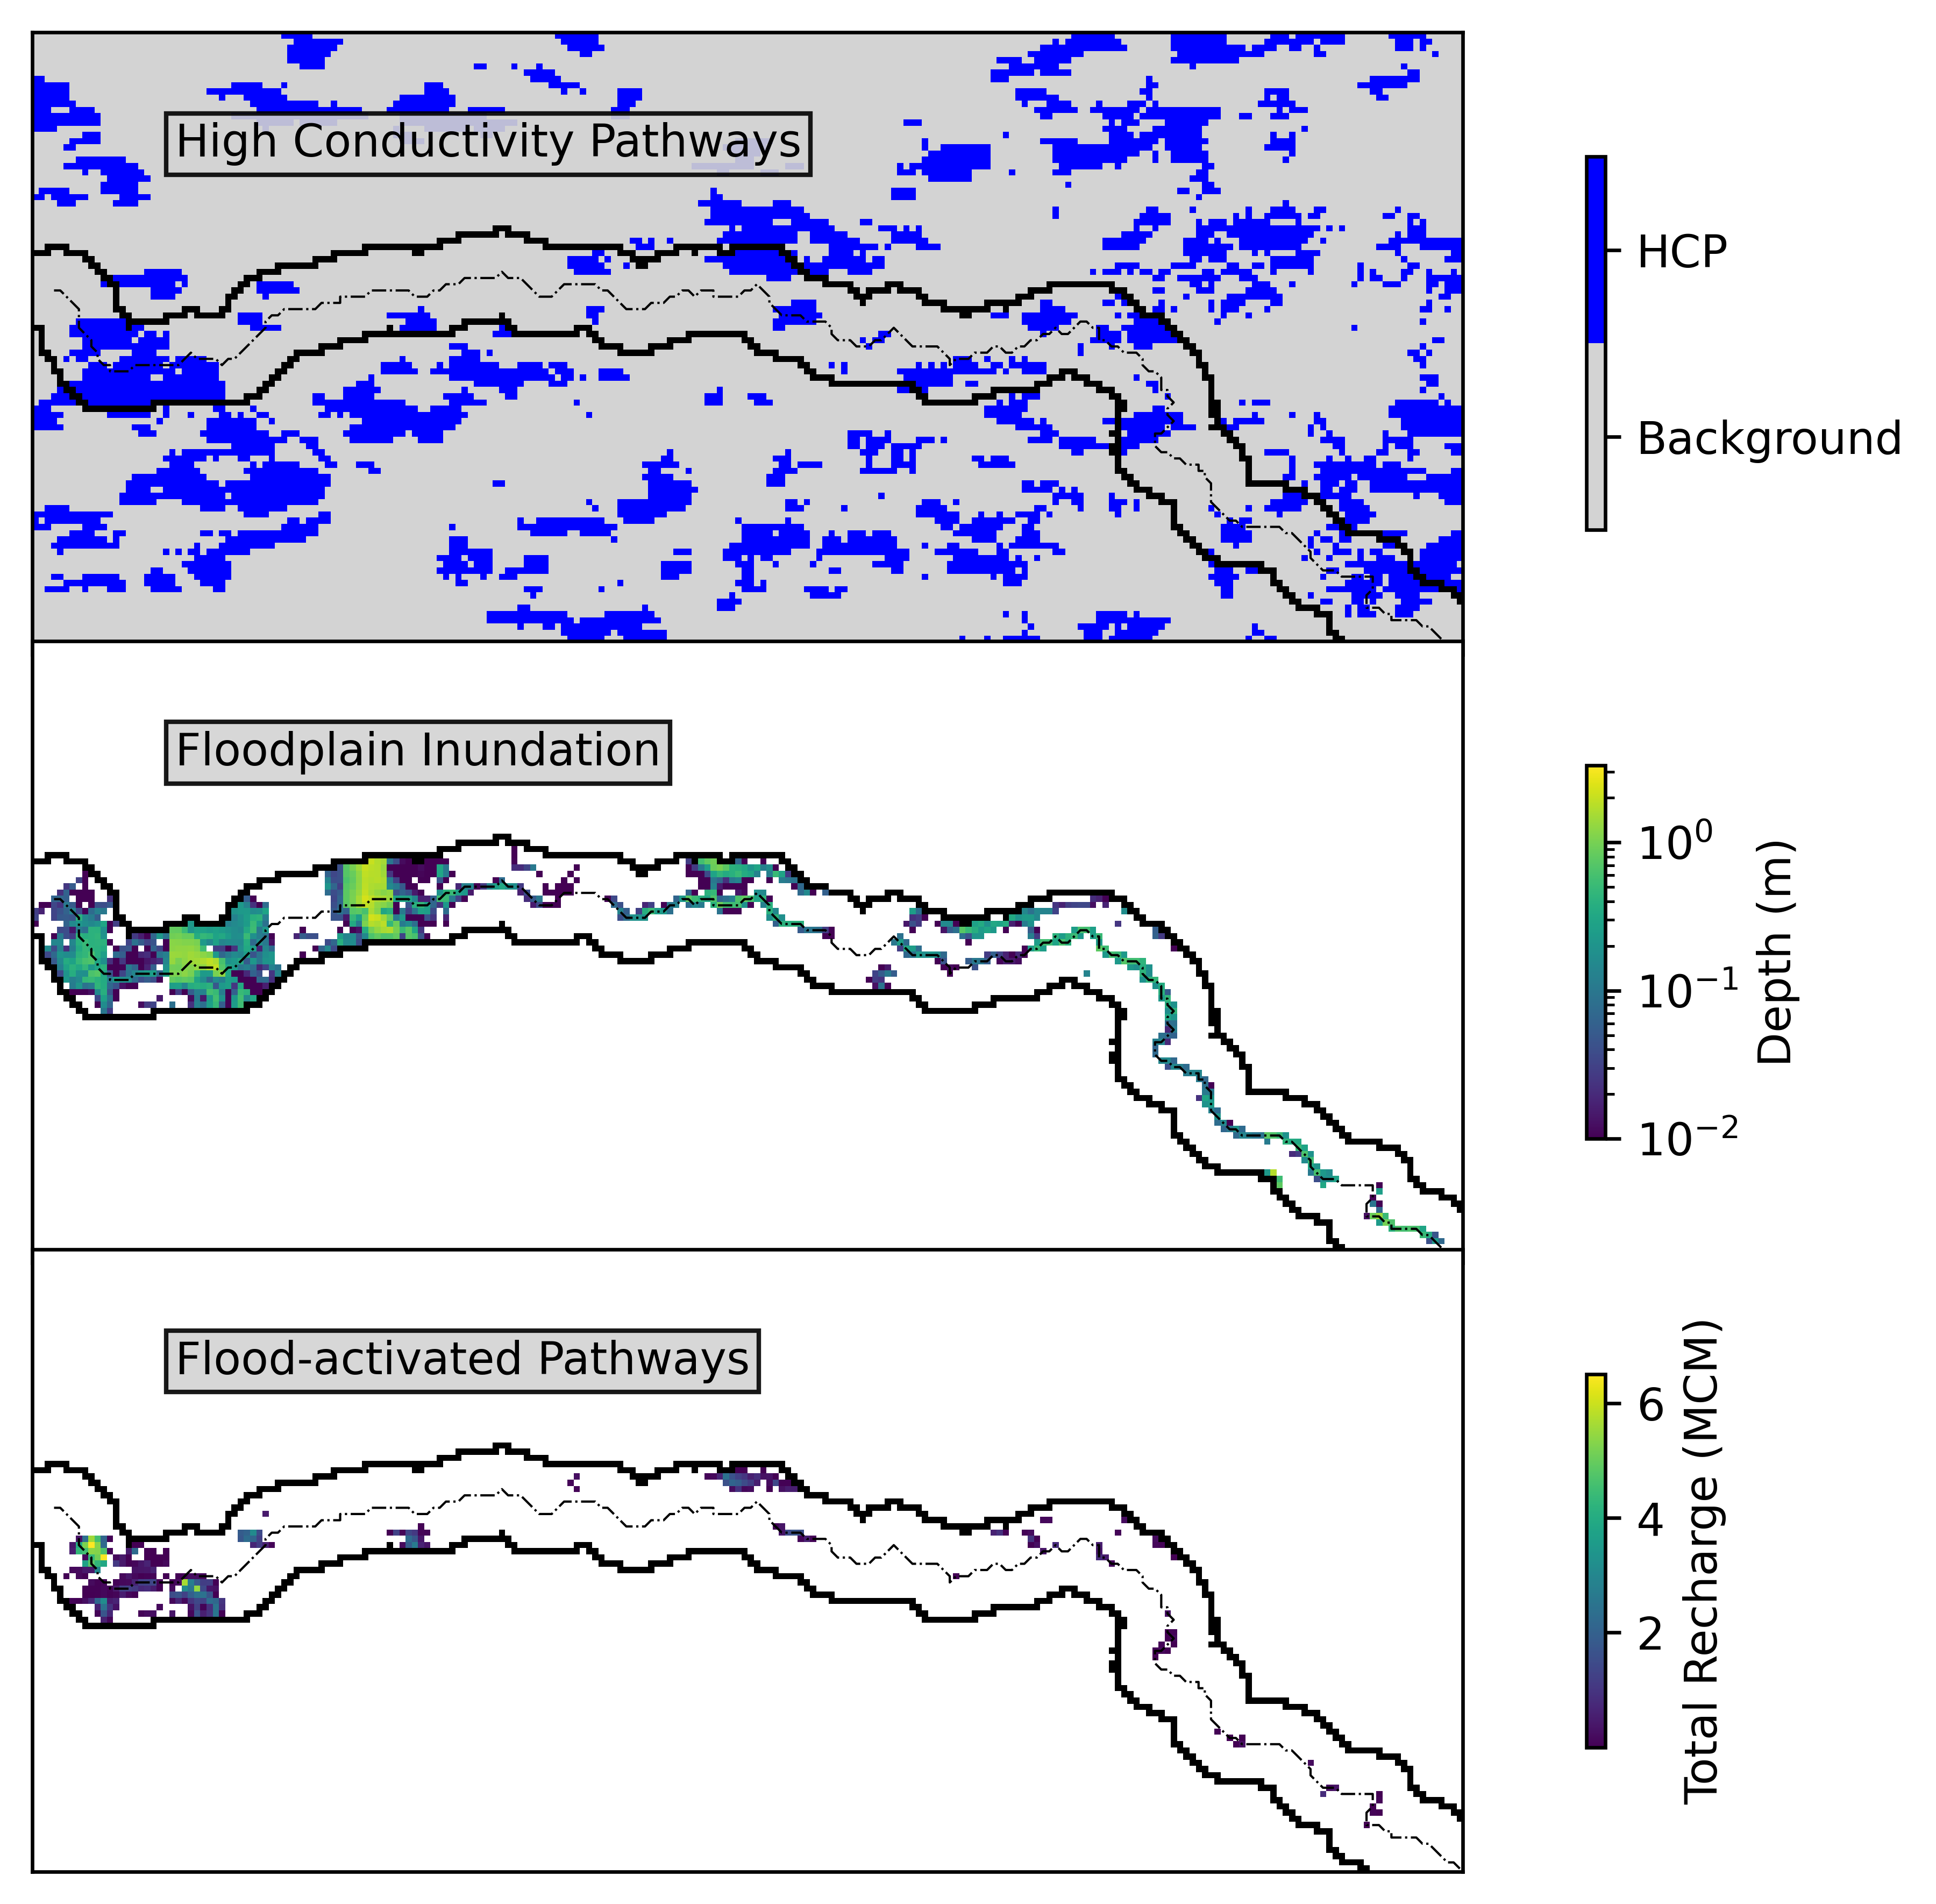

In [126]:
## plot for the methods to show overlay of HCP, flood depth to recharge

fig, ax = plt.subplots(3,1, dpi=600,figsize=(8,6), sharex=True)
plt.setp(ax, xticks=[], yticks=[])

## plot HCPs
ax_n = ax[0]
im = ax_n.imshow(hf_tot[t],cmap=cmap)
# color bar on all rows, with two discrete labels
cbar=plt.colorbar(mappable = im, ax=ax_n,  ticks = [0.25,.75], shrink= 0.6)
cbar.ax.set_yticklabels(['Background', 'HCP'])
## plot flood depth
ax_n = ax[1]
nf = 2 
d_plt = np.ma.masked_invalid(d_arr.mean(axis=0)[s])
d_plt = np.ma.masked_where(d_plt==0,d_plt)

im = ax_n.imshow(d_plt, 
                 norm = mpl.colors.LogNorm(vmin = 1E-2, vmax = np.nanmax(d_arr)),
                 zorder=1
                )
plt.colorbar(im, ax=ax_n, orientation='vertical', label='Depth (m)', shrink=0.6,location='right')
## plot recharge
ax_n = ax[2]
temp = rch_hf_arr.sum(axis=0)[s]*86400*1E-6
im = ax_n.imshow(np.ma.masked_where(temp==0, temp))
plt.colorbar(im, ax=ax_n, orientation='vertical', label='Total Recharge (MCM)', shrink=0.6,location='right')

title = ['High Conductivity Pathways', 'Floodplain Inundation','Flood-activated Pathways']
for n in np.arange(0,3):
    ax_n = ax[n]
    ax_n.imshow(setback_outer, cmap='gray') # works when dpi=600
    ax_n.plot(grid_sfr.column-1, grid_sfr.row-1, color='black', linewidth=0.5, linestyle='-.')
    ax_n.annotate(text = title[n], xy=(0.1,0.8), xycoords='axes fraction',
                  bbox={'facecolor': 'lightgray', 'alpha': 0.9, 'pad': 2})


fig.tight_layout(h_pad=-.3) 


210.64459744207053

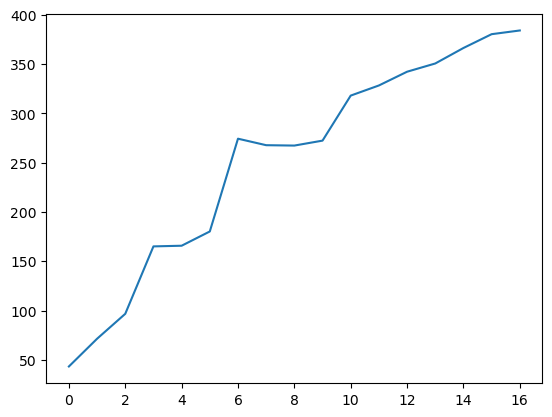

In [123]:
plt.plot(np.nansum(rch_hf_arr,axis=(0,2,3))*86400*1E-6)
np.nansum(rch_hf_arr[s])*86400*1E-6 # MCM

In [127]:
d_plt.max(), d_plt.mean(), d_plt.min()
# typical flow 

(2.2779977787083543, 0.28768489133460196, 8.67336399814539e-06)

## Simplified HCP with flood depth to recharge (Archived)

[]

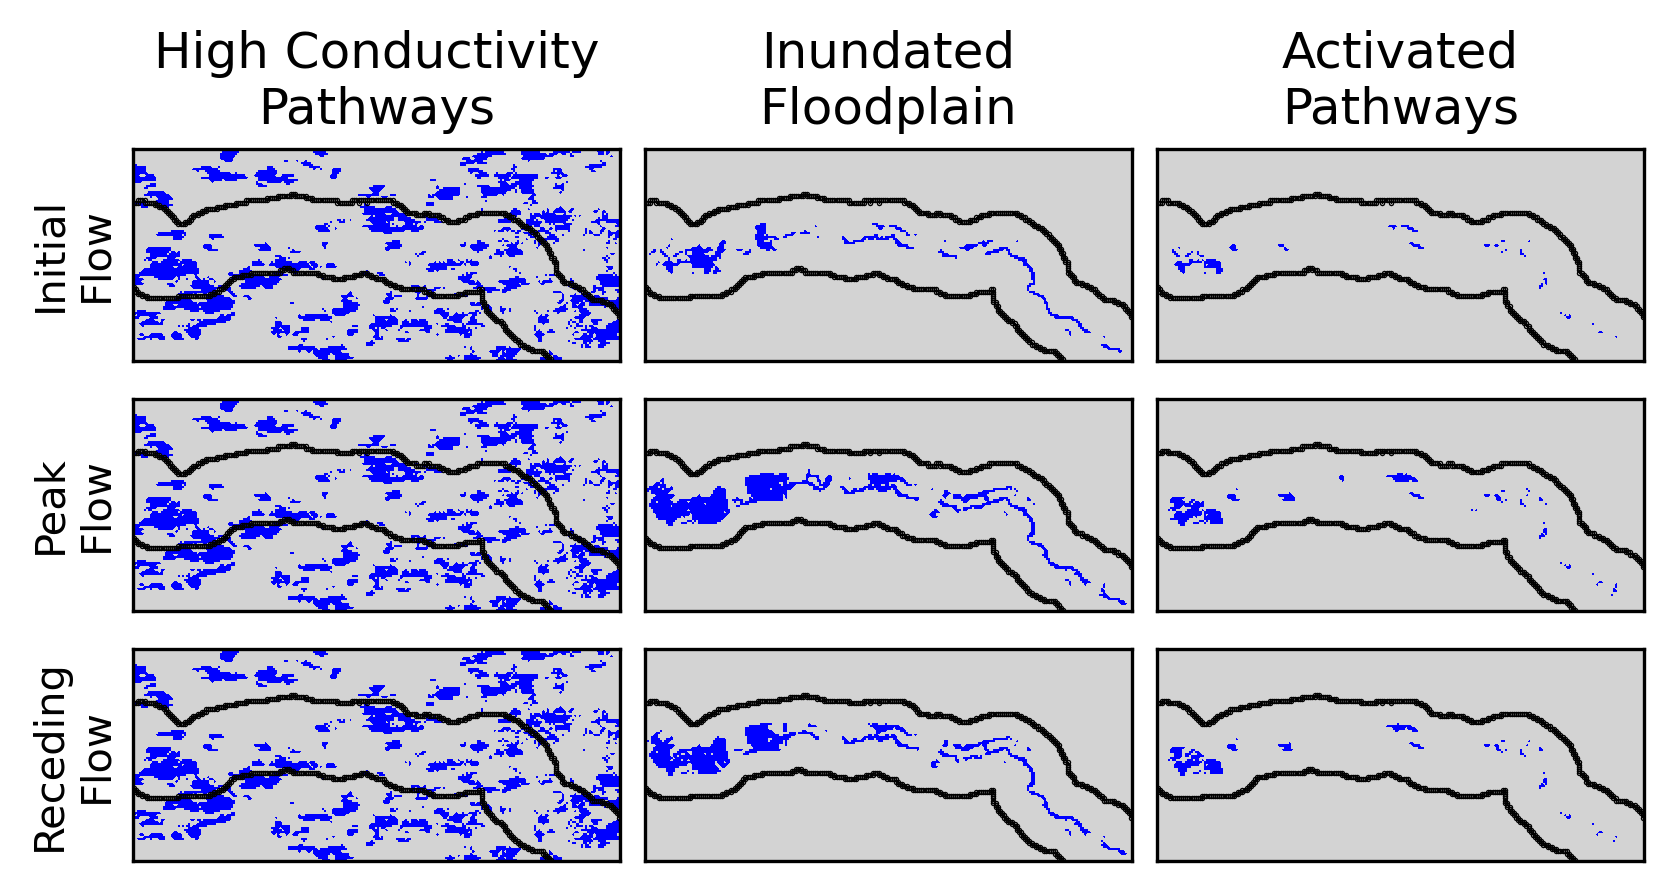

In [54]:

# show change in activated pathways by either setback distance impact on flooded area or
# flood flow impact
fig,ax=plt.subplots(3,3, figsize=(6.5, 6.5), sharex=True, sharey=True, dpi=300)
# fig.tight_layout(hspsace=0.2, wspace=0.2)
plt.subplots_adjust(hspace=-0.75, wspace=0.05)

s=6
# initial, peak, half way receded
for i,qn in enumerate([0, tp, int(tp+(T-tp)/2)]):
#     ax[i,0].imshow(hf_tot[t])
    im = ax[i,0].imshow(hf_tot[t],cmap=cmap)

    ax[i,1].imshow(d_arr[qn,s,:]>0, cmap=cmap)
#     ax[i,1].imshow(d_mask[qn,s,:])

    ax[i,2].imshow(rch_hf_arr[qn,s,:]>0, cmap=cmap)
    for n in np.arange(0,3):
        ax[i,n].scatter(setback_grid.column-1, setback_grid.row-1, color='black', s=0.1)
    
# axis labels
ax[0,0].set_ylabel('Initial\nFlow')
ax[1,0].set_ylabel('Peak\nFlow')
ax[2,0].set_ylabel('Receding\nFlow')

# color bar on all rows, with two discrete labels
# cbar=plt.colorbar(mappable = im, ax=ax[2,0],  ticks = [0.25,.75], shrink= 0.7, orientation='horizontal')
# cbar.ax.set_yticklabels(['Low flow facies', 'High flow facies'])

# titles
ax[0,0].set_title('High Conductivity\nPathways')
ax[0,1].set_title('Inundated\nFloodplain')
ax[0,2].set_title('Activated\nPathways')

plt.setp(ax, xticks=[], yticks=[])
